In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install -q keras

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
%matplotlib inline

In [9]:
print(tf.__version__)

2.8.0


In [10]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-7b73d928-b11e-6530-e600-4f9c647add24)


In [11]:
cd /content/drive/MyDrive/Driver Drowsiness Prediction

/content/drive/MyDrive/Driver Drowsiness Prediction


# **Dataset Loading, Plotting and Preprocessing**

In [12]:
train_path = '/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/train'
test_path = '/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/test'

In [13]:
import os
class_folders = os.listdir(train_path)
class_folders

['Open', 'Closed', 'yawn', 'no_yawn']

In [14]:
len(class_folders)

4

In [17]:
import json

class_dict = {"0":'Open', "1":'Closed', "2":'yawn', "3":'no_yawn'}
json_string = json.dumps(class_dict)
json_file = open("label_info.json", "w")
json_file.write(json_string)
json_file.close()

In [18]:
with open('label_info.json','r') as f:
    label_info=f.read()

In [19]:
label_info=json.loads(label_info)

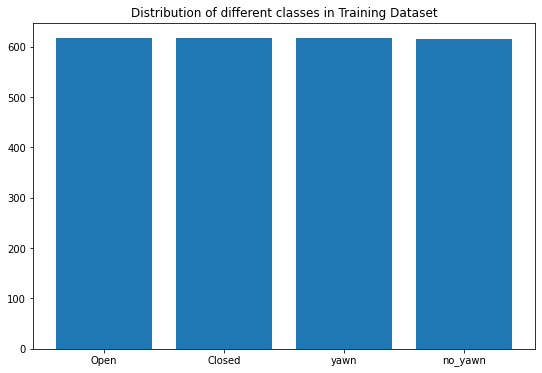

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

image_folder = ['Open', 'Closed', 'yawn', 'no_yawn']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/train/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

In [21]:
train_dataset_open = '/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/train/Open/'
train_dataset_closed = '/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/train/Closed/'
train_dataset_yawn = '/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/train/yawn/'
train_dataset_no_yawn = '/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/train/no_yawn/'


In [22]:
print(len(os.listdir(train_dataset_open)))
print(len(os.listdir(train_dataset_closed)))
print(len(os.listdir(train_dataset_yawn)))
print(len(os.listdir(train_dataset_no_yawn)))


617
617
617
616


In [23]:
random_value_open = np.random.randint(0, len(os.listdir(train_dataset_open)))
random_value_closed = np.random.randint(0, len(os.listdir(train_dataset_closed)))
random_value_yawn = np.random.randint(0, len(os.listdir(train_dataset_yawn)))
random_value_no_yawn = np.random.randint(0, len(os.listdir(train_dataset_no_yawn)))

In [24]:
random_open_eye_pic = os.listdir(train_dataset_open)[random_value_open] # index Location datasets[index]
print("Random open eye pic ", random_open_eye_pic)
random_open_eye_pic_load = Image.open(train_dataset_open+random_open_eye_pic)

random_closed_eye_pic = os.listdir(train_dataset_closed)[random_value_closed] # index Location datasets[index]
print("Random closed eye pic ", random_closed_eye_pic)
random_closed_eye_pic_load = Image.open(train_dataset_closed+random_closed_eye_pic)

random_yawn_eye_pic = os.listdir(train_dataset_yawn)[random_value_yawn] # index Location datasets[index]
print("Random yawn eye pic ", random_yawn_eye_pic)
random_yawn_eye_pic_load = Image.open(train_dataset_yawn+random_yawn_eye_pic)

random_no_yawn_eye_pic = os.listdir(train_dataset_no_yawn)[random_value_no_yawn] # index Location datasets[index]
print("Random no yawn eye pic ", random_no_yawn_eye_pic)
random_no_yawn_eye_pic_load = Image.open(train_dataset_no_yawn+random_no_yawn_eye_pic)

Random open eye pic  _659.jpg
Random closed eye pic  _720.jpg
Random yawn eye pic  422.jpg
Random no yawn eye pic  146.jpg


Text(0.5, 1.0, 'No yawn')

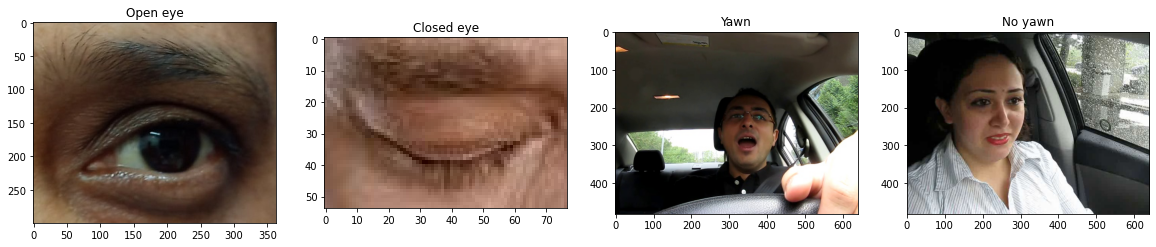

In [25]:
f  = plt.figure(figsize = (20, 13)) # frame Size

subplot = f.add_subplot(1, 4, 1)
img_load_plot = plt.imshow(random_open_eye_pic_load)
subplot.set_title("Open eye")

subplot = f.add_subplot(1, 4, 2)
img_load_plot = plt.imshow(random_closed_eye_pic_load)
subplot.set_title("Closed eye")

subplot = f.add_subplot(1, 4, 3)
img_load_plot = plt.imshow(random_yawn_eye_pic_load)
subplot.set_title("Yawn")

subplot = f.add_subplot(1, 4, 4)
img_load_plot = plt.imshow(random_no_yawn_eye_pic_load)
subplot.set_title("No yawn")

In [51]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range = 0.2,
                                                                shear_range = 0.2,
                                                                zoom_range = 0.2,
                                                                horizontal_flip = True,
                                                                vertical_flip = True, 
                                                                fill_mode='nearest' )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)
train_set = train_datagen.flow_from_directory(train_path,
                                                    batch_size = 16,
                                                    class_mode = 'categorical', 
                                                    target_size = (256, 256))
test_set = test_datagen.flow_from_directory(test_path,
                                                  batch_size = 16,
                                                  class_mode = 'categorical', 
                                                  target_size = (256, 256))

Found 2467 images belonging to 4 classes.
Found 433 images belonging to 4 classes.


In [35]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob

In [52]:
IMAGE_SIZE = [256, 256]

## **VGG16 Implementation**

In [29]:
 # Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [59]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [60]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [61]:
prediction = Dense(len(class_folders), activation='softmax')(x)

# create a model object
model_vgg16 = Model(inputs=vgg16.input, outputs=prediction)

In [47]:
# view the structure of the model
# model_vgg16.summary()

In [62]:
# tell the model what cost and optimization method to use
model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [63]:
len(test_set)

28

In [64]:
# fit the model
# Run the cell. It will take some time to execute
trainedmodel_vgg16 = model_vgg16.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
155/155 [==============================] - 66s 418ms/step - loss: 0.7301 - accuracy: 0.7098 - val_loss: 0.3878 - val_accuracy: 0.8222
Epoch 2/20
155/155 [==============================] - 65s 417ms/step - loss: 0.6633 - accuracy: 0.7690 - val_loss: 1.1325 - val_accuracy: 0.7945
Epoch 3/20
155/155 [==============================] - 64s 409ms/step - loss: 0.5966 - accuracy: 0.7941 - val_loss: 0.4139 - val_accuracy: 0.8291
Epoch 4/20
155/155 [==============================] - 63s 407ms/step - loss: 0.5078 - accuracy: 0.8176 - val_loss: 0.4787 - val_accuracy: 0.8291
Epoch 5/20
155/155 [==============================] - 63s 407ms/step - loss: 0.6010 - accuracy: 0.8006 - val_loss: 0.3734 - val_accuracy: 0.8522
Epoch 6/20
155/155 [==============================] - 65s 416ms/step - loss: 0.5536 - accuracy: 0.8208 - val_loss: 0.4046 - val_accuracy: 0.8522
Epoch 7/20
155/155 [==============================] - 64s 409ms/step - loss: 0.6939 - accuracy: 0.7965 - val_loss: 0.5384 - val_ac

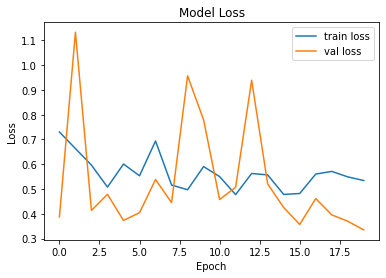

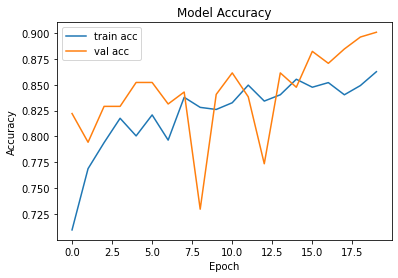

In [67]:
# plot the loss
history_trainloss = trainedmodel_vgg16.history['loss']
history_testloss = trainedmodel_vgg16.history['val_loss']
plt.plot(history_trainloss, label='train loss')
plt.plot(history_testloss, label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
#plt.savefig('loss_vgg16')

# plot the accuracy
history_trainaccuracy = trainedmodel_vgg16.history['accuracy']
history_testaccuracy = trainedmodel_vgg16.history['val_accuracy']
plt.plot(history_trainaccuracy, label='train acc')
plt.plot(history_testaccuracy, label='val acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
#plt.savefig('accuracy_vgg16')

In [68]:
history_testloss =  trainedmodel_vgg16.history['val_loss']
print(history_testloss)

[0.3877646028995514, 1.1325308084487915, 0.4138566553592682, 0.4786917567253113, 0.3734248876571655, 0.40463173389434814, 0.5384419560432434, 0.4452991187572479, 0.9565649032592773, 0.7791939973831177, 0.457750529050827, 0.5073575973510742, 0.9389684796333313, 0.5206118822097778, 0.4255760908126831, 0.3571198284626007, 0.46166756749153137, 0.3959406316280365, 0.37016353011131287, 0.33518290519714355]


In [69]:
model_vgg16.save('drowsiness_vgg16.h5')

In [71]:
reconstructed_model = load_model("/content/drive/MyDrive/Driver Drowsiness Prediction/drowsiness_vgg16.h5")

In [72]:
y_pred = reconstructed_model.predict(test_set)
y_pred

array([[2.6568058e-24, 4.8532581e-13, 2.5824085e-01, 7.4175918e-01],
       [7.7546749e-05, 9.9992239e-01, 1.3593364e-10, 4.2982473e-10],
       [6.2439998e-05, 9.9993753e-01, 1.3939641e-08, 6.5213485e-10],
       ...,
       [7.8382890e-12, 1.0000000e+00, 4.0845882e-11, 8.6157524e-13],
       [3.3812258e-16, 1.0000000e+00, 1.2666655e-10, 3.7769006e-14],
       [7.2348565e-01, 2.7651417e-01, 1.7436905e-08, 1.4961240e-07]],
      dtype=float32)

In [ ]:
#trainedmodel_vgg16.predict(test_set)

In [73]:
!dir

driver_drowsiness_dataset	    drowsiness_vgg16.h5
driver_drowsiness_prediction.ipynb  label_info.json


In [ ]:
cd /content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/test/Open/

/content/drive/MyDrive/Driver Drowsiness Prediction/driver_drowsiness_dataset/test/Open


In [ ]:
from keras.preprocessing import image
test_img = '_107.jpg'
img = image.load_img(test_img, target_size=(256, 256))
x = image.img_to_array(img)
x=x/255
x=x.reshape(1, 256, 256, 3)

In [ ]:
cd /content/drive/MyDrive/Driver Drowsiness Prediction

In [ ]:

y_pred = reconstructed_model.predict(x)
y_pred

array([[1.6728950e-07, 9.9999845e-01, 4.0162039e-08, 1.3383128e-06]],
      dtype=float32)

In [ ]:
import numpy as np
np.argmax(y_pred[0])

1

In [ ]:
label_info["1"]

'Closed'

In [ ]:
y_pred = reconstructed_model.predict(test_set)
y_pred

array([[1.13814582e-04, 2.93750617e-07, 4.80484128e-01, 5.19401789e-01],
       [9.99950171e-01, 4.97197470e-05, 1.09506555e-08, 1.32684576e-07],
       [2.04213473e-04, 8.93850029e-07, 8.03656518e-01, 1.96138322e-01],
       ...,
       [4.38727206e-03, 9.95609820e-01, 3.45110784e-08, 2.93434982e-06],
       [1.09526610e-07, 1.52518056e-04, 1.77639708e-01, 8.22207749e-01],
       [5.89846705e-09, 1.32741420e-07, 2.33696610e-01, 7.66303241e-01]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
y_pred

array([3, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 3, 3, 0, 3, 1, 3, 0, 1, 1, 2, 3,
       2, 3, 0, 1, 1, 3, 2, 3, 0, 1, 3, 1, 1, 3, 0, 1, 2, 2, 1, 0, 3, 1,
       0, 1, 1, 0, 3, 0, 0, 2, 3, 1, 0, 3, 3, 0, 1, 2, 2, 1, 3, 1, 3, 1,
       0, 3, 3, 1, 0, 3, 1, 0, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 2, 2, 1, 0,
       2, 3, 0, 3, 3, 0, 3, 3, 2, 1, 0, 3, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 3, 1, 2, 2, 3, 0, 0, 2, 3, 0, 0,
       0, 0, 0, 3, 0, 1, 0, 2, 3, 1, 0, 3, 3, 1, 0, 1, 0, 2, 0, 3, 2, 2,
       0, 0, 3, 3, 3, 2, 0, 1, 0, 1, 3, 2, 0, 2, 1, 2, 0, 2, 3, 0, 1, 0,
       1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 2, 2, 2, 0, 0, 3, 2, 1, 3, 1, 2,
       0, 0, 1, 3, 3, 0, 0, 3, 0, 0, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2,
       3, 1, 3, 2, 3, 1, 2, 0, 2, 3, 3, 1, 3, 2, 2, 2, 3, 3, 3, 3, 2, 0,
       0, 3, 1, 0, 3, 1, 2, 3, 0, 2, 2, 0, 0, 1, 3, 2, 0, 0, 3, 0, 3, 3,
       3, 3, 2, 0, 3, 3, 1, 2, 0, 1, 0, 1, 2, 0, 1, 3, 3, 0, 0, 0, 1, 1,
       0, 0, 1, 3, 2, 2, 3, 3, 0, 0, 1, 3, 1, 2, 3,

In [ ]:
test_set

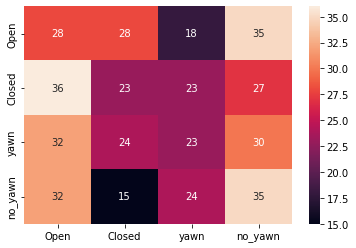

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_folders, yticklabels=class_folders)

In [ ]:
target_names = ['Open', 'Closed', 'yawn', 'no_yawn']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Open       0.22      0.26      0.24       109
      Closed       0.26      0.21      0.23       109
        yawn       0.26      0.21      0.23       109
     no_yawn       0.28      0.33      0.30       106

    accuracy                           0.25       433
   macro avg       0.25      0.25      0.25       433
weighted avg       0.25      0.25      0.25       433



# **Resnet50 Implementation**

In [ ]:
resnet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet50.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet50.output)

In [ ]:
prediction = Dense(len(class_folders), activation='softmax')(x)

# create a model object
model_resnet50 = Model(inputs=resnet50.input, outputs=prediction)

In [ ]:
 # model.summary()

In [ ]:
model_resnet50.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
trainedmodel_resnet50 = model_resnet50.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
155/155 [==============================] - 71s 427ms/step - loss: 3.2774 - accuracy: 0.5043 - val_loss: 3.0616 - val_accuracy: 0.5589
Epoch 2/10
155/155 [==============================] - 65s 416ms/step - loss: 1.4787 - accuracy: 0.6295 - val_loss: 3.2524 - val_accuracy: 0.6467
Epoch 3/10
 23/155 [===>..........................] - ETA: 50s - loss: 1.7495 - accuracy: 0.6603

KeyboardInterrupt: ignored

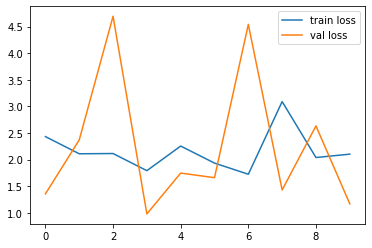

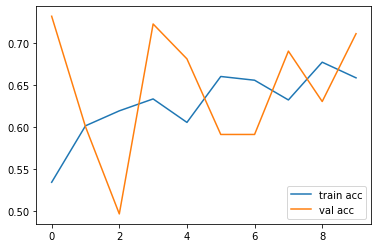

In [ ]:
# plot the loss
plt.plot(trainedmodel_resnet50.history['loss'], label='train loss')
plt.plot(trainedmodel_resnet50.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('loss_resnet50')

# plot the accuracy
plt.plot(trainedmodel_resnet50.history['accuracy'], label='train acc')
plt.plot(trainedmodel_resnet50.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('accuracy_resnet50')

In [ ]:
print(trainedmodel_resnet50.history['val_loss'])

[0.9769817590713501, 0.590442419052124]


In [ ]:
model_resnet50.save('drowsiness_resnet50.h5')

In [ ]:
#reconstructed_model = load_model("/content/drive/MyDrive/Colab Notebooks/model_resnet50.h5")

In [ ]:
#y_pred = reconstructed_model.predict(test_set)
#y_pred

In [ ]:
#y_pred = np.argmax(y_pred, axis=1)
#y_pred

# **InceptionV3 Implementation**

In [ ]:
inceptionv3 = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inceptionv3.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(inceptionv3.output)

In [ ]:
prediction = Dense(len(class_folders), activation='softmax')(x)

# create a model object
model_inceptionv3 = Model(inputs=inceptionv3.input, outputs=prediction)

In [ ]:
 # model.summary()

In [ ]:
model_inceptionv3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
trainedmodel_inceptionv3 = model_inceptionv3.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
155/155 [==============================] - 74s 433ms/step - loss: 3.1564 - accuracy: 0.7629 - val_loss: 2.4515 - val_accuracy: 0.7852
Epoch 2/10
155/155 [==============================] - 63s 408ms/step - loss: 2.7263 - accuracy: 0.8216 - val_loss: 3.0853 - val_accuracy: 0.8083
Epoch 3/10
155/155 [==============================] - 63s 408ms/step - loss: 3.0172 - accuracy: 0.8310 - val_loss: 1.0556 - val_accuracy: 0.8868
Epoch 4/10
155/155 [==============================] - 63s 405ms/step - loss: 3.4686 - accuracy: 0.8399 - val_loss: 2.1041 - val_accuracy: 0.8453
Epoch 5/10
155/155 [==============================] - 63s 408ms/step - loss: 3.3463 - accuracy: 0.8391 - val_loss: 2.3793 - val_accuracy: 0.8637
Epoch 6/10
155/155 [==============================] - 63s 404ms/step - loss: 2.9322 - accuracy: 0.8500 - val_loss: 1.3502 - val_accuracy: 0.9122
Epoch 7/10
155/155 [==============================] - 64s 411ms/step - loss: 3.4194 - accuracy: 0.8610 - val_loss: 1.1940 - val_ac

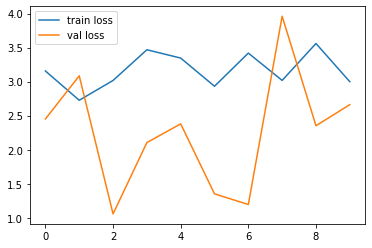

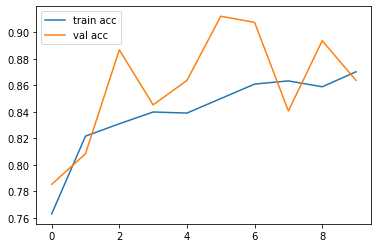

In [ ]:
# plot the loss
plt.plot(trainedmodel_inceptionv3.history['loss'], label='train loss')
plt.plot(trainedmodel_inceptionv3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('loss_inceptionv3')

# plot the accuracy
plt.plot(trainedmodel_inceptionv3.history['accuracy'], label='train acc')
plt.plot(trainedmodel_inceptionv3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('accuracy_inceptionv3')

In [ ]:
print(trainedmodel_inceptionv3.history['val_loss'])

[0.5057554841041565, 0.5149416327476501]


In [ ]:
model_inceptionv3.save('drowsiness_inceptionv3.h5')

In [ ]:
#reconstructed_model = load_model("/content/drive/MyDrive/Colab Notebooks/model_inceptionv3.h5")

In [ ]:
#y_pred = reconstructed_model.predict(test_set)
#y_pred

In [ ]:
#y_pred = np.argmax(y_pred, axis=1)
#y_pred

# **Xception Implementation**

In [88]:
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [89]:
for layer in xception.layers:
  layer.trainable = False

In [90]:
x = Flatten()(xception.output)

In [91]:
prediction = Dense(len(class_folders), activation='softmax')(x)

# create a model object
model_xception = Model(inputs=xception.input, outputs=prediction)

In [92]:
 # model.summary()

In [93]:
model_xception.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [94]:
trainedmodel_xception = model_xception.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
155/155 [==============================] - 75s 456ms/step - loss: 2.6044 - accuracy: 0.7718 - val_loss: 1.3855 - val_accuracy: 0.8291
Epoch 2/25
155/155 [==============================] - 67s 430ms/step - loss: 2.1968 - accuracy: 0.8391 - val_loss: 1.6205 - val_accuracy: 0.8499
Epoch 3/25
155/155 [==============================] - 69s 446ms/step - loss: 2.0484 - accuracy: 0.8520 - val_loss: 1.4708 - val_accuracy: 0.8476
Epoch 4/25
155/155 [==============================] - 69s 447ms/step - loss: 2.3161 - accuracy: 0.8549 - val_loss: 1.3441 - val_accuracy: 0.8476
Epoch 5/25
155/155 [==============================] - 68s 438ms/step - loss: 2.5427 - accuracy: 0.8561 - val_loss: 3.2374 - val_accuracy: 0.8176
Epoch 6/25
155/155 [==============================] - 68s 440ms/step - loss: 2.5486 - accuracy: 0.8614 - val_loss: 1.4725 - val_accuracy: 0.8845
Epoch 7/25
155/155 [==============================] - 68s 441ms/step - loss: 2.3567 - accuracy: 0.8792 - val_loss: 2.3052 - val_ac

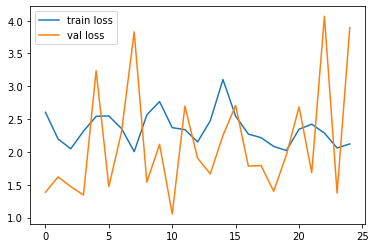

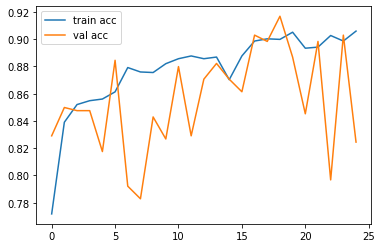

In [95]:
# plot the loss
plt.plot(trainedmodel_xception.history['loss'], label='train loss')
plt.plot(trainedmodel_xception.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('loss_xception')

# plot the accuracy
plt.plot(trainedmodel_xception.history['accuracy'], label='train acc')
plt.plot(trainedmodel_xception.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('accuracy_xception')

In [96]:
print(trainedmodel_xception.history['val_loss'])

[1.3855255842208862, 1.6204901933670044, 1.4707785844802856, 1.344140887260437, 3.2374444007873535, 1.472464919090271, 2.3052399158477783, 3.829279899597168, 1.5388662815093994, 2.1172142028808594, 1.0559560060501099, 2.6978678703308105, 1.905063271522522, 1.666966199874878, 2.2520740032196045, 2.7089147567749023, 1.7848968505859375, 1.7935060262680054, 1.4003026485443115, 1.9557973146438599, 2.685143232345581, 1.6842325925827026, 4.067573547363281, 1.3737486600875854, 3.8940646648406982]


In [97]:
model_xception.save('drowsiness_xception.h5')

In [ ]:
#reconstructed_model = load_model("/content/drive/MyDrive/Colab Notebooks/model_xception.h5")

In [ ]:
#y_pred = reconstructed_model.predict(test_set)
#y_pred

In [ ]:
#y_pred = np.argmax(y_pred, axis=1)
#y_pred

# **EfficientNetB7 Implementation**

In [79]:
efficientnetb7 = EfficientNetB7(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [80]:
for layer in efficientnetb7.layers:
  layer.trainable = False

In [81]:
x = Flatten()(efficientnetb7.output)

In [82]:
prediction = Dense(len(class_folders), activation='softmax')(x)

# create a model object
model_efficientnetb7 = Model(inputs=efficientnetb7.input, outputs=prediction)

In [ ]:
 # model.summary()

In [83]:
model_efficientnetb7.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [84]:
trainedmodel_efficientnetb7 = model_efficientnetb7.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
155/155 [==============================] - 133s 690ms/step - loss: 26.0537 - accuracy: 0.2598 - val_loss: 17.9469 - val_accuracy: 0.2517
Epoch 2/20
155/155 [==============================] - 100s 642ms/step - loss: 14.5707 - accuracy: 0.2578 - val_loss: 5.8537 - val_accuracy: 0.2517
Epoch 3/20
155/155 [==============================] - 100s 642ms/step - loss: 16.7420 - accuracy: 0.2371 - val_loss: 11.5861 - val_accuracy: 0.2517
Epoch 4/20
155/155 [==============================] - 100s 642ms/step - loss: 18.4784 - accuracy: 0.2708 - val_loss: 5.0846 - val_accuracy: 0.2448
Epoch 5/20
155/155 [==============================] - 100s 642ms/step - loss: 15.8483 - accuracy: 0.2452 - val_loss: 21.1715 - val_accuracy: 0.2517
Epoch 6/20
155/155 [==============================] - 100s 642ms/step - loss: 17.9575 - accuracy: 0.2465 - val_loss: 18.5473 - val_accuracy: 0.2448
Epoch 7/20
155/155 [==============================] - 100s 642ms/step - loss: 15.0603 - accuracy: 0.2574 - val_los

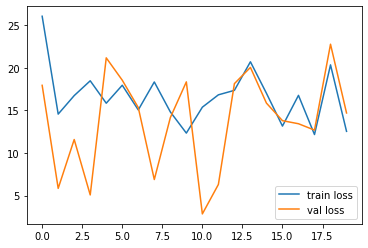

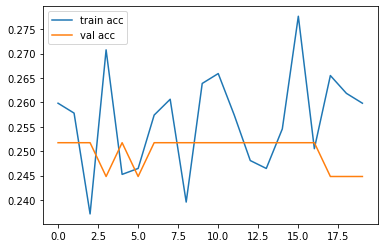

In [85]:
# plot the loss
plt.plot(trainedmodel_efficientnetb7.history['loss'], label='train loss')
plt.plot(trainedmodel_efficientnetb7.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('loss_efficientnetb7')

# plot the accuracy
plt.plot(trainedmodel_efficientnetb7.history['accuracy'], label='train acc')
plt.plot(trainedmodel_efficientnetb7.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('accuracy_efficientnetb7')

In [86]:
print(trainedmodel_efficientnetb7.history['val_loss'])

[17.946937561035156, 5.853725433349609, 11.586102485656738, 5.084575653076172, 21.171480178833008, 18.54730987548828, 15.33448600769043, 6.892441272735596, 14.150688171386719, 18.351364135742188, 2.856017827987671, 6.311413288116455, 18.143375396728516, 20.047903060913086, 15.859879493713379, 13.798787117004395, 13.439212799072266, 12.692848205566406, 22.771183013916016, 14.701778411865234]


In [87]:
model_efficientnetb7.save('drowsiness_efficientnetb7.h5')

In [ ]:
#reconstructed_model = load_model("/content/drive/MyDrive/Colab Notebooks/model_efficientnetb7.h5")

In [ ]:
#y_pred = reconstructed_model.predict(test_set)
#y_pred

In [ ]:
#y_pred = np.argmax(y_pred, axis=1)
#y_pred